In [22]:
import os
import random
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import nltk
from stop_words import get_stop_words
from stempel import StempelStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from utils import *

## The dataset

* Loading data and labels using a custom function
* Displaying random data examples for each label
* Displaying the percentage of each class

In [23]:
zip_file_path = os.path.join("data", "task_6-2.zip")
data_txt_file_name = "training_set_clean_only_text.txt"
labels_txt_file_name = "training_set_clean_only_tags.txt"

data, labels = load_data_and_labels_from_zip(zip_file_path,
                                             data_txt_file_name,
                                             labels_txt_file_name)
display_samples(data, labels, n_samples=2)

Examples with label 0:
Text: @anonymized_account @anonymized_account @anonymized_account Dokładnie, też miałam ze swoją niezle przeboje
Text: @anonymized_account Trzęsący się jak galareta  @anonymized_account bo sędzia na emeryturze zjadł parówkę

Examples with label 1:
Text: @anonymized_account @anonymized_account @anonymized_account I się schowam, pisz debilu
Text: Sabrino, tępa kurwo, miałaś iść do lasu a nie sadu XDDD

Examples with label 2:
Text: @anonymized_account Kurwa  cały tt śmierdzi przez ciebie
Text: @anonymized_account @anonymized_account Szacunku dla tych bogoojczyźnianych zjebów,vperfekcyjnych w dojeniu państwa



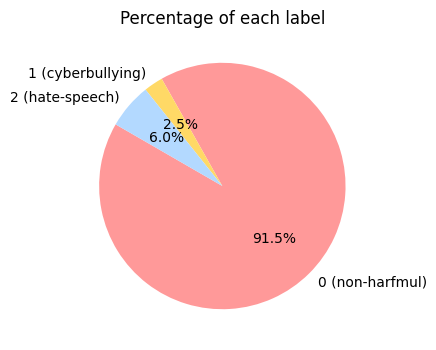

In [41]:
display_class_distribution(labels)